<a href="https://colab.research.google.com/github/foxtrotmike/Survival-PaTaRI/blob/main/Surviving%20Survival%20Analysis%20-%20II%20(Python%20Notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surviving Survival Analysis - II

# by

# Papers, Thoughts and Research Insights (PaTaRI)    -- TIA Centre

From this notebook, you can learn

(1) how to use Random survival forest and do performance eval on simulated data.

(2) how to use regression coefficients of the fitted model to predict the risk score which can be used as a new feature for patient stratification

(3) how to use Survival SVM and do performance eval on simulated data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading Data

In [ ]:
# Load the dataset into a Pandas dataframe
import os
import pandas as pd
data_dir = os.path.join('/content', 'gdrive', 'My Drive', 'Colab Notebooks', 'survival_analysis')
dataset_path = os.path.join(data_dir, 'example_dataset.csv')
dataset = pd.read_csv(dataset_path)

In [ ]:
dataset

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,time,event
0,1.475876,-1.776096,4.915642,122.0,98.094698,5.972386,1.660803,-1.864064,118.0,7.660347,0.000000,0.0
1,6.962669,-1.252591,19.444990,111.0,-8.769640,8.096565,23.921275,-0.451359,131.0,-1.836969,0.000000,0.0
2,4.974584,-1.443488,-2.923769,109.0,69.898629,5.883239,11.301937,-3.209809,132.0,0.825555,2.149633,1.0
3,6.565848,-0.209302,15.752279,118.0,-9.126213,7.206371,15.295552,-1.707323,117.0,2.551161,1.311286,1.0
4,8.185607,0.997027,8.567676,119.0,24.094598,7.853565,12.516080,-0.047749,127.0,6.001835,0.215496,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.740516,0.687209,13.657878,110.0,76.031360,2.031302,17.613828,-0.716146,123.0,0.553241,0.000000,0.0
996,1.637833,-0.224637,22.426366,121.0,69.115131,7.563708,11.802899,-0.311101,107.0,5.578604,0.000000,0.0
997,6.441727,-1.003687,0.796903,129.0,47.684423,7.378485,9.815511,-2.160617,128.0,8.668370,0.000000,0.0
998,6.669404,0.326433,18.004485,121.0,-14.890240,-0.599931,6.783380,-3.588625,123.0,5.390423,1.893789,1.0


In [ ]:
pip install pysurvival

     |████████████████████████████████| 4.8MB 4.4MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773001 sha256=61a2454685f8278631022d084fd10ce3fe61741d3348293548398d0cc8a75b0e
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp37-none-any.whl size=12083 sha256=e89dce72ec78f7a2839a74fa988b9e139521b87775e8a619df7c541f4dd70c30
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar


In [ ]:
pip install lifelines

     |████████████████████████████████| 358kB 3.2MB/s 
     |████████████████████████████████| 61kB 4.3MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4050 sha256=8dde0fc3c5ec620eae99aec2232eb9dd3f391ab38ace3d4f4097a0f8674f0b09
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


# Use Random survival forest and do performance eval on simulated data

In [ ]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
from lifelines import CoxPHFitter

In [ ]:
# Building training and testing sets #
features = ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6','x_7', 'x_8', 'x_9', 'x_10']
index_train, index_test = train_test_split( range(len(dataset)), test_size = 0.2)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
# Creating the X, T and E input
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values

In [ ]:
# Creating an instance of the Conditional model and fitting the data.
# Building the model
rsf = RandomSurvivalForestModel(num_trees=200)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

RandomSurvivalForestModel

C-index: 0.79


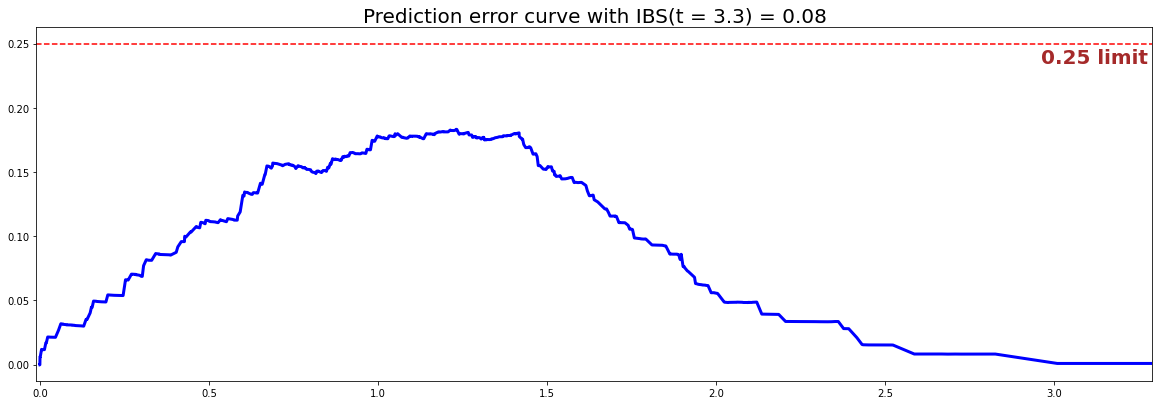

IBS: 0.08


In [ ]:
# Model Performances
c_index = concordance_index(rsf, X_test, T_test, E_test) 
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(rsf, X_test, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

There is few average squared distances between the real survival status and the predicted survival probability.

In [ ]:
# importance of each feature (the higher, the more important the feature is)
rsf.variable_importance

{'x_1': 14.675974035835994,
 'x_10': 19.2224379748396,
 'x_2': 10.052471032717966,
 'x_3': 21.30334363017534,
 'x_4': 9.964859795340452,
 'x_5': 17.292089523707983,
 'x_6': 12.57424803022011,
 'x_7': 10.252355912352945,
 'x_8': 11.544660447493259,
 'x_9': 13.490742560998074}

Here, x_3 and x_10 are the two most important features. One can decide the involvement of features by evaluating the feature importance.

In [ ]:
# Generate risk score as the new feature on both discovery and validation sets
risk_score_train = rsf.predict_risk(X_train)
risk_score_test = rsf.predict_risk(X_test)

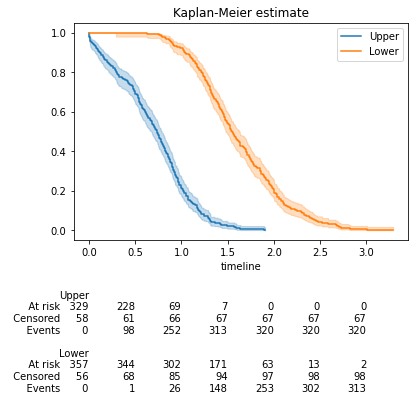

<Figure size 432x288 with 0 Axes>

In [ ]:
# Use mean value in the discovery set as the cut-off value and divide subjects into two groups
cutoff_value = risk_score_train.mean()
upper = risk_score_train>cutoff_value
T_upper_train = data_train['time'][upper]
E_upper_train = data_train['event'][upper]
lower = risk_score_train<=cutoff_value
T_lower_train = data_train['time'][lower]
E_lower_train = data_train['event'][lower]
# Initializing the KaplanMeierModel for each group
km_upper = KaplanMeierFitter()
km_lower = KaplanMeierFitter()

# Fitting the model 
T = data_train['time'].values
E = data_train['event'].values
ax = plt.subplot(111)
ax = km_upper.fit(T_upper_train, event_observed=E_upper_train, label = 'Upper').plot_survival_function(ax=ax)
ax = km_lower.fit(T_lower_train, event_observed=E_lower_train, label = 'Lower').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(km_upper, km_lower, ax=ax)
plt.title('Kaplan-Meier estimate')
plt.ylabel('Survival probability')
plt.show()
plt.tight_layout()

In [ ]:
# Log-rank test: if there is any significant difference between the groups being compared
from lifelines.statistics import logrank_test
results = logrank_test(T_lower_train, T_upper_train, E_lower_train, E_upper_train)
# print metrics
print("p-value on the discovery set %s; log-rank %s" % (results.p_value, np.round(results.test_statistic, 6)))

p-value on the discovery set 1.542635796823874e-115; log-rank 522.014495


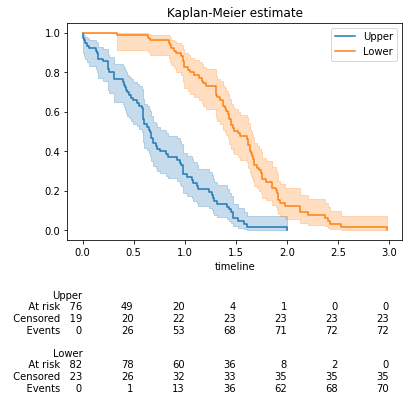

<Figure size 432x288 with 0 Axes>

In [ ]:
# Use mean value in the discovery set as the cut-off value and divide subjects int the validation set into two groups
upper = risk_score_test>cutoff_value
T_upper_test = data_test['time'][upper]
E_upper_test = data_test['event'][upper]
lower = risk_score_test<=cutoff_value
T_lower_test = data_test['time'][lower]
E_lower_test = data_test['event'][lower]
# Initializing the KaplanMeierModel for each group
km_upper = KaplanMeierFitter()
km_lower = KaplanMeierFitter()

# Fitting the model 
T = data_test['time'].values
E = data_test['event'].values
ax = plt.subplot(111)
ax = km_upper.fit(T_upper_test, event_observed=E_upper_test, label = 'Upper').plot_survival_function(ax=ax)
ax = km_lower.fit(T_lower_test, event_observed=E_lower_test, label = 'Lower').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(km_upper, km_lower, ax=ax)
plt.title('Kaplan-Meier estimate')
plt.ylabel('Survival probability')
plt.show()
plt.tight_layout()

In [ ]:
# Log-rank test: if there is any significant difference between the groups being compared
results = logrank_test(T_lower_test, T_upper_test, E_lower_test, E_upper_test)
# print metrics
print("p-value on the validation set %s; log-rank %s" % (results.p_value, np.round(results.test_statistic, 6)))

p-value on the validation set 3.026767875049921e-17; log-rank 71.326927


In [ ]:
from lifelines.utils import concordance_index
data_test['rsf_risk'] = risk_score_test
data_test = data_test[[ 'rsf_risk', 'time', 'event']]
cph = CoxPHFitter().fit(data_test, 'time', 'event')
cindex = concordance_index(data_test['time'], -cph.predict_partial_hazard(data_test), data_test['event'])
# print metrics
print("c-index on the validation set %s" % (cindex))

c-index on the validation set 0.8020131129374827


The risk score feature is shown significant in both discovery and validation cohorts. (p-value< 0.005 and c-index around 0.80)

# Use Survival SVM and do performance eval on simulated data

In [ ]:
# Creating an instance of the SurvivalSVM model and fitting the data.
from pysurvival.models.svm import KernelSVMModel
from pysurvival.utils.metrics import concordance_index

svm_model = KernelSVMModel(kernel='Gaussian', scale=0.25)
svm_model.fit(X_train, T_train, E_train, init_method='orthogonal',
    with_bias = True, lr = 0.8,  tol = 1e-3,  l2_reg = 1e-4)

Performing Newton-Raphson optimization: 
 * Iteration #1 - Loss = 12.262 - ||grad||^2 = 455.33887 - ||diff_w|| = 21.79978
 * Iteration #2 - Loss = 7.767 - ||grad||^2 = 90.84894 - ||diff_w|| = 3.92512
 * Iteration #3 - Loss = 7.618 - ||grad||^2 = 22.85359 - ||diff_w|| = 1.10772
 * Iteration #4 - Loss = 7.618 - ||grad||^2 = 5.07884 - ||diff_w|| = 0.31612
 * Iteration #5 - Loss = 7.620 - ||grad||^2 = 1.11775 - ||diff_w|| = 0.09079
 * Iteration #6 - Loss = 7.621 - ||grad||^2 = 0.26692 - ||diff_w|| = 0.02618
 * Iteration #7 - Loss = 7.621 - ||grad||^2 = 0.06238 - ||diff_w|| = 0.00768
 * Iteration #8 - Loss = 7.621 - ||grad||^2 = 0.01747 - ||diff_w|| = 0.00215
 * Iteration #9 - Loss = 7.621 - ||grad||^2 = 0.00489 - ||diff_w|| = 0.00060
 * Iteration #10 - Loss = 7.621 - ||grad||^2 = 0.00137 - ||diff_w|| = 0.00017
 * Iteration #11 - Loss = 7.621 - ||grad||^2 = 0.00038 - ||diff_w|| = 0.00005
Converged after 11 iterations.


KernelSVMModel

In [ ]:
# Model Performances
c_index = concordance_index(svm_model, X_test, T_test, E_test) 
print('C-index: {:.2f}'.format(c_index))

C-index: 0.82


In [ ]:
# Generate risk score 
svm_risk_score_train = svm_model.predict_risk(X_train)
svm_risk_score_test = svm_model.predict_risk(X_test)

As mentioned in Random survival forest, here you can generate risk score fitted by Survival SVM as a new feature for survival analysis.